## Project: **Finding Lane Lines on the Road** 
***

In this project, I will perform lane line detection on road recordings. This project is provided within Udacity Self driving Car Engineer Nanodegree program. The provided dataset consists of road recordings where the road markings are visible, and the goal is to outline the lane lines of the visible road.

First, I will try and apply a few image processing techniques on single images, observe the results, and then proceed to build a pipeline that can be applied to a video stream. 

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

## Import Packages

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from scipy import stats
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


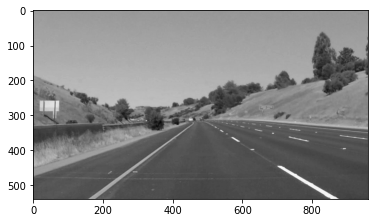

In [3]:
# Reading in an image
image = mpimg.imread('test_images/solidYellowCurve2.jpg')

# Converting to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(gray, cmap = 'gray')

## Helper Functions

Let us first define some helper functions that may come in handy

In [4]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def rgb_to_hsl(img):
    """Converts the image to HSL scale"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size=5):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(image, lines, color=[255, 0, 0], thickness=10):
    """
    Draws the given lines onto the given image
    """
    # Copy the passed image
    img = image.copy()
    
    for line in lines:
        x1,y1,x2,y2 = line[0]
        
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    
    return img

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img, lines


def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Let us first test several techniques and process the images provided in the test directory.

In [5]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



In this section, we start the process of building a pipeline that gives good results in terms of lane line detection on the test images

I will try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

### 1. Preprocessing

After looking at the different pictures, I realized that the two colors a line can take are white and yellow. Thus, the first step is to build a threshold such that the only colors remaining in the image are white and yellow.
To simplify the color selection process, let us first convert the image into the HSL format (Hue, Saturation, Lightness). This format is just a way to store images that is supposed to be closer to the human psychological perception of colors.

In [6]:
# First Preprocessing step: Converting to HSL (Hue, Saturation, Lightness) & retain only yellow and white

def yellow_white_thresholding(image):
    # Copy image
    img = image.copy()
    
    # Converting to HSL
    hsl = rgb_to_hsl(image)

    # Defining yellow threshold
    low_yellow = np.array([15, 38, 115], dtype=int)
    high_yellow = np.array([35, 204, 255], dtype=int)

    # Defining white threshold
    low_white = np.array([0, 200, 0], dtype=int)
    high_white = np.array([180, 255, 255], dtype=int)

    # Computing intermediary masks
    yellow_msk = cv2.inRange(hsl, low_yellow, high_yellow)
    white_msk = cv2.inRange(hsl, low_white, high_white)

    # Computing resulting mask
    mask = yellow_msk | white_msk
    mask = np.reshape(mask, (np.shape(mask)[0], np.shape(mask)[1], 1))

    # Apply mask to image
    new_img = img & mask

    return new_img

image = mpimg.imread('test_images/solidYellowCurve2.jpg')
new_img = yellow_white_thresholding(image)


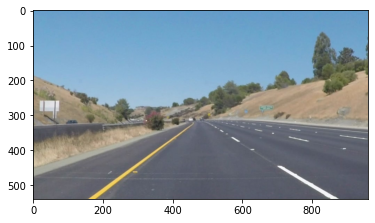

In [7]:
# Let us see the orinial image
plt.imshow(image)

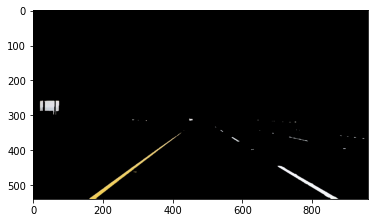

In [8]:
# Now let's take a look at the obtained image
plt.imshow(new_img)
# We see immediately that the yellow and white lines are outlined

Now that we have discarded all the useless colors, let us convert the image to grayscale, to make things easier

Then, we proceed to apply the following filters:

- A gaussian kernel, to smooth out the image before looking for edges
- A canny transform, to look for edges in the image. Due to the high contrast between the lines and their neighborhood, the edges should be points belonging to the lane lines

In [9]:
# Now let us apply several filters to the obtained image

def gray_gaussian_canny(image, show = False, **kwargs):
    
    # Copying the image
    img = image.copy()

    # Converting to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian Kernel
    kernel_size = kwargs.pop('kernel_size', 5)
    smoothed_image = gaussian_blur(gray, kernel_size)

    # Apply Canny
    low_threshold = kwargs.pop('low_threshold', 50)
    high_threshold = kwargs.pop('high_threshold', 150)
    edges = canny(smoothed_image, low_threshold, high_threshold)

    # Show image
    if show:
        plt.figure()
        plt.title('Image after Gaussian smoothing and Canny Edges detection')
        plt.imshow(edges, cmap = 'gray')
    
    return edges

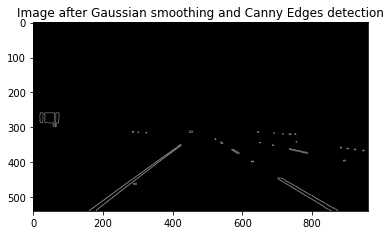

In [10]:
# Taking a look at the image
# We can see that the obtained edges indeed belong to the lane lines
edge_img = gray_gaussian_canny(new_img, show = True, kernel_size = 5, low_threshold = 50, high_threshold = 150)

Now, let us carve out the region of interest. The vertices of the polygon of interest are defined manually, but could also be set automatically

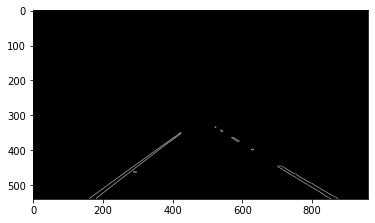

In [11]:
# Keeping the region of interest
vertices = [np.array([[150, 539], [430, 325], [510, 325], [880, 539]])]
cut_image = region_of_interest(edge_img, vertices)

# Taking a look at the resulting image
plt.imshow(cut_image, cmap = 'gray')

### 2. Lane Finding

Now that the edges belonging to the lane lines are obtained, let us apply the Hough Transform to extract the lines out of the given edges.
The Hough transform is simply a way to represent lines as points in a different frame, and vice versa.

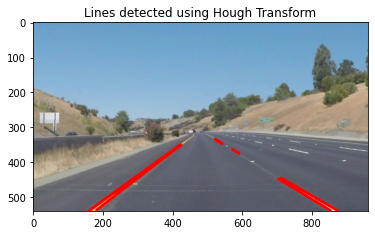

In [12]:
# Let us first extract the lines of the images using Hough Transform.

def hough_transform(original_image, cut_image, show = False, **kwargs):

    # Copying the image
    img = cut_image.copy()

    # Applying the Hough Transform
    rho = kwargs.pop('rho', 1)
    theta = kwargs.pop('theta', np.pi/180)
    threshold = kwargs.pop('threshold', 10)
    min_line_len = kwargs.pop('min_line_length', 20)
    max_line_gap = kwargs.pop('max_line_gap', 20)

    _, lines = hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap)
    
    # Let us draw the lines on the image
    drawn_image = draw_lines(original_image, lines, thickness=5)
    
    # Show the resulting image
    if show:
        plt.figure()
        plt.title('Lines detected using Hough Transform')
        plt.imshow(drawn_image, cmap = 'gray')
        
    return drawn_image, lines


# Let us apply the Hough transform to our image and print the result
drawn_image, lines = hough_transform(image, cut_image, show = True)
    

Now that we've obtained the lines in our image, we need to separate the lines belonging to the left lane line and the right lane line.

The obvious criterion for separation is the sign of the slope of each line: Positive slope = right line, Negative slope = left line.

Then, to obtain a single line for each lane, I developped three different methods:
- The first one simply uses Linear Regression to compute the slope and interception point of the left and right line

- The second one proceeds as follow: once the lines are separated in two clusters (left lane lines and right lane lines), I look for the line in each cluster that has the highest norm. I then assigned the slope and interception point of the line representing the cluster as the ones from the retrieved line with the highest norm.

- The third one builds the slope and interception point of the representative line of each cluster using the average of slope and interception point of the corresponding cluster (the average is weighted using the norm of each constituting line) 



In [13]:
# Let us now regroup lines in two clusters: left lines and right lines
# The obvious criterion for separation is the sign of the slope
# Positive slope = right line, Negative slope = left line (Warning: Y axis is reversed!)

def split_lines(lines, image_shape):
    left_lines = []
    right_lines = []
    height, length, _ = image_shape
    eps = 1e-2
    for i in range(len(lines)):
        x1, y1, x2, y2 = lines[i][0]

        # Pass if vertical or horizontal line
        if abs(x2 - x1) < eps or abs(y2 - y1) < eps:
            continue

        # Compute the slope
        slope = (y2 - y1)/(x2 - x1)
        
        # Left Line
        if slope < 0 and x2 <= length / 2:
            left_lines.append([x1, y1, x2, y2])

        # Right Line
        if slope > 0 and x1 >= length / 2:
            right_lines.append([x1, y1, x2, y2])
        
    return left_lines, right_lines

def interpolate_line(lines, method = 'Linear Regression'):
    x, y = [], []
    
    min_y = float('inf')


    if method == 'Linear Regression':
        for line in lines:
            x1, y1, x2, y2 = line
            x += [x1, x2]
            y += [y1, y2]

            min_y = min(min_y, y1, y2)
        
        interp = stats.linregress(x,y)
        
        return interp.intercept, interp.slope, min_y


    if method == 'Max Norm':
        
        max_norm = - float('inf')
        max_norm_slope = 0
        max_norm_intercep = 0
        for line in lines:
            x1, y1, x2, y2 = line
            min_y = min(min_y, y1, y2)
            slope = (y2 - y1)/(x2 - x1)
            intercep = y2 - (slope * x2)
            norm = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            
            
            if norm > max_norm:
                max_norm_slope = slope
                max_norm_intercep = y2 - (slope * x2)
                max_norm = norm
        
        return max_norm_intercep, max_norm_slope, min_y
        
    
    if method == 'Average':
        count = 0
        avg_slope = 0
        avg_intercep = 0
        for line in lines:
            x1, y1, x2, y2 = line
            min_y = min(min_y, y1, y2)

            norm = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            slope = (y2 - y1)/(x2 - x1)
            intercep = y2 - (slope * x2)

            avg_slope += slope*norm
            avg_intercep += intercep*norm
            count += norm
        
        return avg_intercep/count, avg_slope/count, min_y



In [14]:
# Let us now apply the above functions to our image
# I can pick the method I want using method = 'Average' / 'Max Norm' / 'Linear Regression'
left_lines, right_lines = split_lines(lines, np.shape(image))
left_intercep, left_slope, left_min_y = interpolate_line(left_lines, method = 'Average')
right_intercep, right_slope, right_min_y = interpolate_line(right_lines, method = 'Average')

min_y = max(left_min_y, right_min_y)
left_coords = left_intercep, left_slope
right_coords = right_intercep, right_slope
coords = [left_coords, right_coords]

Now that we obtained the coordinates of the left and right lane lines, we need to check if these lines do indeed characterize the lane separations correctly.

In [15]:
# Let us now define a function that draws these two lanes on the image

def draw_lane(image, coords, min_y, color = [255, 0, 0], thickness = 20):

    height, length, _ = np.shape(image)
    img = image.copy()

    # left line
    intercep, slope = coords[0]
    x_start = (height - 1 - intercep)/slope
    x1, y1 = x_start, height-1
    y2 = min_y
    x2 = (y2 - intercep)/slope

    # Drawing the left line
    cv2.line(img, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness)


    # right line
    intercep, slope = coords[1]
    x_start = (height - 1 - intercep)/slope
    x2, y2 = x_start, height-1
    y1 = min_y
    x1 = (y1 - intercep)/slope

    # Drawing the right line
    cv2.line(img, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness)


    # resulting image
    res_img = weighted_img(img, image, α=0.8, β=1., γ=0.)

    return res_img

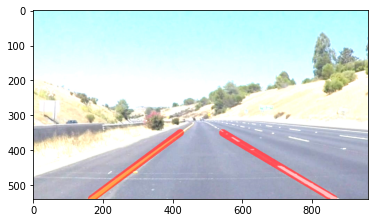

In [16]:
# Now let us see how this looks like !
# We can try out different ways of computing the lanes, by changing the method of interpolation !
resulting_img = draw_lane(image, coords, min_y)
plt.imshow(resulting_img)

Now that we've tested our pipeline on simple test images, let us regroup all these functions into a main get_lines function, and print the results once applied to the test images.

In [17]:
def get_lines(image):
    
    # White and yellow thresholding
    new_img = yellow_white_thresholding(image)

    # Preprocessing step
    edge_img = gray_gaussian_canny(new_img, show = False, kernel_size = 5, low_threshold = 50, high_threshold = 150)

    # Region of interest
    vertices = [np.array([[150, 539], [430, 325], [510, 325], [880, 539]])]
    cut_image = region_of_interest(edge_img, vertices)

    # Hough transform and lines
    drawn_image, lines = hough_transform(image, cut_image, show = False)

    # Finding left and right lines
    left_lines, right_lines = split_lines(lines, np.shape(image))

    try:
        left_intercep, left_slope, left_min_y = interpolate_line(left_lines, method = 'Linear Regression')
    except ValueError:
        return image

    try:
        right_intercep, right_slope, right_min_y = interpolate_line(right_lines, method = 'Linear Regression')
    except ValueError:
        return image
    min_y = min(left_min_y, right_min_y)
    min_y = 340
    left_coords = left_intercep, left_slope
    right_coords = right_intercep, right_slope
    coords = [left_coords, right_coords]

    # Drawing the lines
    resulting_img = draw_lane(image, coords, min_y)

    return resulting_img

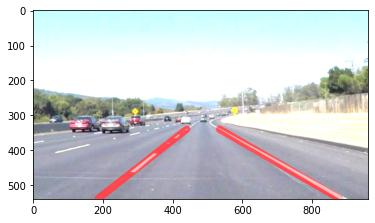

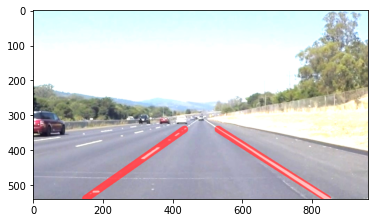

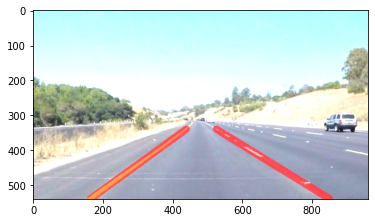

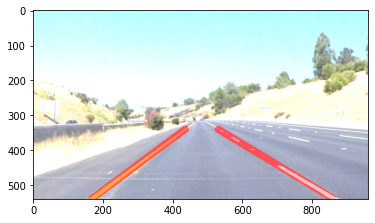

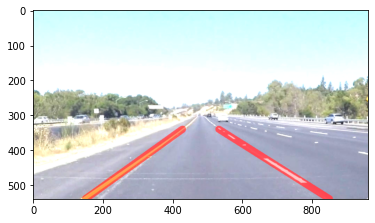

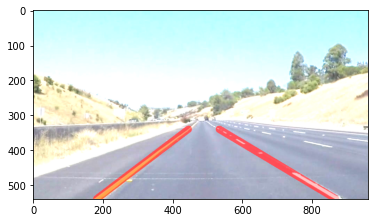

In [18]:
# Now let's see what the lines look like

img_list = []
for img_path in os.listdir("test_images/"):
    image = image = mpimg.imread('test_images/' + img_path)
    res_img = get_lines(image)
    img_list.append(res_img)
    plt.figure()
    plt.imshow(res_img)

## Final step : Testing on videos

Now, let us test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [19]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [20]:
def process_image(image):
    return get_lines(image)

Let's try the one with the solid white lane on the right first ...

In [21]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,6)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: total: 6.02 s
Wall time: 4.51 s


Let us now see what it looks like !

In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [23]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: total: 17.6 s
Wall time: 12.2 s


Let us now see what it looks like !

In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

# Conclusion

In this project, I was able to build a pipeline that recovers the lane lines surrounding the car using the provided videos. On simple scenarios, the pipeline is quite robust: indeed, I implemented three different methods to interpolate the lane lines, which allows for an increased robustness. One method uses a simple linear regression solver, the second uses a smart averaging weighted by the norms of the constituting lines and the last one uses the slope and interception point of the line with maximum norm. However, there are some improvement points:
1. First, the performance begins to drop when lighting conditions are changing a lot (lots of sunlight or shades), which is one point of improvement. This comes from the thresholding part, when we keep only white and yellow colors using specific thresholds. One way to fix that issue would be to compute thresholds specific to the image, that use a measurement of the global lighting of the interest zone to determine how to shift the threshold so as to still keep the colors of interest. In a case of low lightness, one would look to shift the thresholds so as to allow for colors with a lower "lightness parameter" (in the Hue, Saturation, Lightness format). I think this would be a nice improvement.
2. A second improvement would be to build to smooth the line interpolations over time: building a buffer to retain the previously computed slopes and interception points and average those over time, so as to avoid brutal change of slopes that do not happen in reality.
3. Finally, for the cases of lines with a strong curvature, it would be interesting to change the model of interpolation to the one of a higher order polynomial (for now I am interpolating a line: y = ax + b), which would change the Hough Transform step (since we are not looking for lines anymore). The process would be to first identify the edges corresponding to the left and right lane lines, and then fit a polynomial to these edges, to then draw it on the image.